In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import numpy as np
import seaborn as sns
import os
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from tqdm import tqdm
import networkx as nx

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
from nmp.node import Node
from nmp.edge import Edge
from nmp.message_passer import MessagePasser
from nmp.state_updater import StateUpdater
from nmp.nmp_tools import get_lablesx, get_central_node, preprocess_graphx
from nmp.nmp_tools import run_message_passing, make_predictions, get_random_subgraphx

In [4]:
import os
import psutil
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, log_loss
from sklearn.metrics import precision_recall_curve
from IPython.display import clear_output

process = psutil.Process(os.getpid())

In [5]:
device = torch.device('cuda')

## Необходимые приготовления(признаки и архитектуры)

Первое: объявляем функции для извлечения признаков из вершин и рёбер.

In [6]:
from typing import Callable

def node_feature_exctractor(node, node_shape: int):
    return np.array(
                    [
                        (node['features']['SX'] - 50001) / (20 * 1293.),
                        (node['features']['SY'] - 40011) / (20 * 1293.),
                        (node['features']['SZ'] - 36850.5) / (1293 * 57),
                        node['features']['TX'],
                        node['features']['TY'],
                        (node['features']['chi2'] - 1.5) / 1.5
                    ] + (node_shape - 6) * [0.]
                )
def edge_feature_exctractor(edge_uv, edge_shape: int):
    return np.array(
                    [
                        edge_uv['features']['dsx'],
                        edge_uv['features']['dsy'],
                        edge_uv['features']['dsz'],
                        edge_uv['features']['dsxProjLeft'],
                        edge_uv['features']['dsyProjLeft'],
                        edge_uv['features']['dsxProjRight'],
                        edge_uv['features']['dsyProjRight'],
                        (edge_uv['features']['energy']  - 462.) / 1258.,
                        (edge_uv['features']['likelihood']  + 17.) / 20.,
                        (edge_uv['features']['r'] - 200) / 200,

                    ] + (edge_shape - 10) * [0.]
                )

Второе: объявляем нейронки для пересылки сообщений, обновления состояния и readout.

In [7]:
class MessagePasserNN(nn.Module):
    def __init__(self, input, output):
        super().__init__()
        self.layer_1 = nn.Linear(input, 32) # 32 / 64
        self.dropout_1 = nn.Dropout(p=0.01)
        self.nonlinear_1 = nn.LeakyReLU()
        self.layer_2 = nn.Linear(32, 32)
        self.nonlinear_2 = nn.LeakyReLU()
        #self.layer_3 = nn.Linear(32, 32)
        #self.nonlinear_3 = nn.LeakyReLU()
        self.output = nn.Linear(32, output)

    def forward(self, x):
        x = self.nonlinear_1(self.dropout_1(self.layer_1(x)))
        x = self.nonlinear_2(self.layer_2(x))
        #x = self.nonlinear_3(self.layer_3(x))
        return self.output(x)
    
class StateUpdaterNN(nn.Module):
    def __init__(self, input, output):
        super().__init__()
        self.gru = nn.GRUCell(input, output)
    
    def forward(self, x, hidden_state):
        hidden_state = self.gru(x, hidden_state)
        return hidden_state
    
    
class Readout(object):
    def __init__(self, input: int, output: int, readout: nn.Module, device):
        """
        :param scope:
        """
        self.input = input
        self.output = output
        self.device = device
        self.readout = readout(input, output).to(self.device)

    def predict(self, node: 'Node'):
        return self.readout(node.state[None, :])
    
    
class ReadoutNN(nn.Module):
    def __init__(self, input, output):
        super().__init__()
        self.layer_1 = nn.Linear(input, 32)
        self.nonlinear_1 = nn.LeakyReLU()
        self.layer_2 = nn.Linear(32, 32)

        self.mean = nn.Linear(32, output)
        self.sigma = nn.Linear(32, output)
        
    def forward(self, x):
        x = self.nonlinear_1(self.layer_1(x))
        x = self.layer_2(x)
        mean = self.mean(x)
        sigma = self.sigma(x)
        # mean = mean# / mean.norm(dim=1, keepdim=True)
        #sigma = sigma / (1. + sigma.norm(dim=1, keepdim=True)).sqrt()
        return mean, sigma

In [8]:
class WeightedMessages(nn.Module):
    def __init__(self, input):
        super().__init__()
        #self.layer_1 = nn.Linear(input, 8)
        #self.nonlinear_1 = nn.LeakyReLU()
        self.output = nn.Linear(input, 1)
    def forward(self, x):
        #x = self.nonlinear_1(self.layer_1(x))
        return F.sigmoid(self.output(x))
    
wmessages = WeightedMessages(3).to(device)

## Инициализация функций

In [9]:
### shapes of nodes edges and messages
node_shape = 16 # tx, ty, chi2 + zeros
edge_shape = 16 # \delta_x \delta_y r
message_size = 16

### message passers for different steps
message_passer_first = MessagePasser(node_to_size=node_shape, node_from_size=node_shape, 
                               edge_size=edge_shape, message_size=message_size, message_passer=MessagePasserNN, device=device)
message_passer_second = MessagePasser(node_to_size=node_shape, node_from_size=node_shape, 
                               edge_size=edge_shape, message_size=message_size, message_passer=MessagePasserNN, device=device)
message_passer_third = MessagePasser(node_to_size=node_shape, node_from_size=node_shape, 
                               edge_size=edge_shape, message_size=message_size, message_passer=MessagePasserNN, device=device)
message_passer_forth = MessagePasser(node_to_size=node_shape, node_from_size=node_shape, 
                               edge_size=edge_shape, message_size=message_size, message_passer=MessagePasserNN, device=device)

message_passers = {
    0: message_passer_first,
    1: message_passer_second,
    2: message_passer_third,
    3: message_passer_forth
}

### state updater
state_updater = StateUpdater(input=message_size, output=node_shape, state_updater=StateUpdaterNN, device=device) 

### readout function
readout = Readout(input=node_shape, output=3, readout=ReadoutNN, device=device)

Параметры засовываем в словарь, так проще.

## Загрузка данных

In [11]:
from glob import glob
files = glob('./data/brick_cleaned_*.pkl')[:1]

In [12]:
from tools.opera_tools import *

train_data = []

for file in files:
    print(file)
    graphx=nx.read_gpickle(file)
    graphx_connected_components = []
    degrees = nx.Graph(graphx).degree
    nodes_to_delete = []
    for node, degree in degrees:
        if degree == 0:
            nodes_to_delete.append(node)
    graphx.remove_nodes_from(nodes_to_delete)
    
    for connected_component in tqdm(nx.connected_components(nx.Graph(graphx)), leave=False):
        if len(connected_component) > 100:
            graphx_connected_components.append(graphx.subgraph(connected_component))
    for graphx_candidate in tqdm(graphx_connected_components, leave=False):
        lablesx_candidate = get_lablesx(graphx_candidate)
        if np.sum(np.unique(list(lablesx_candidate.values()), return_counts=True)[1][1:] > 150) > 1:
            train_data.append(nx.DiGraph(graphx_candidate))

/home/vbelavin/home/anaconda3/envs/rootenv/lib/python3.6/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.14.2 is currently installed but you installed root_numpy against numpy 1.12.1. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)


./data/brick_cleaned_10.pkl


In [13]:
### optimizer
params_trainable = (
    list(message_passer_first.message_passer.parameters()) + 
    list(message_passer_second.message_passer.parameters()) + 
    list(message_passer_third.message_passer.parameters()) + 
    list(message_passer_forth.message_passer.parameters()) + 
    list(readout.readout.parameters()) + 
    list(wmessages.parameters()) + 
    list(state_updater.state_updater.parameters()))
print('Number of trainable parameters {}'.format(sum([p.numel() for p in params_trainable])))
optimizer_params = optim.RMSprop(params_trainable, lr=1e-3)

params_mpnn = dict(
    optimizer_params=optimizer_params,
    node_shape=node_shape,
    edge_shape=edge_shape,
    readout=readout,
    layers=5,
    threshold=300,
    message_passers=message_passers,
    state_updater=state_updater,
    node_feature_exctractor=node_feature_exctractor,
    edge_feature_exctractor=edge_feature_exctractor,
    order=-1,
    steps=2,
    margin=2.,
    wmessages=wmessages,
    device=device
)

Number of trainable parameters 16810


In [15]:
from tqdm import tqdm
def preprocess_graphx(graphx: nx.DiGraph, 
                      node_shape: int, 
                      edge_shape: int, 
                      layers: float,
                      threshold: float,
                      message_passers: dict, 
                      state_updater: StateUpdater,
                      node_feature_exctractor: Callable, 
                      edge_feature_exctractor: Callable,
                      device,
                      order: int = -1,
                      balanced=True, **kwargs):
    """
    if order <= 0 => the whole graph is proceeded
    """
    """
    edges = list(graphx.edges())
    graphx.remove_edges_from(edges)
    
    DISTANCE = 1293.
    edges_to_add = []
    for node_id_left, node_left in tqdm(graphx.nodes(data=True), leave=False):
        for node_id_right, node_right in graphx.nodes(data=True):
            if node_left['features']['SZ'] == node_right['features']['SZ']:
                continue
            if node_left['features']['SZ'] > node_right['features']['SZ']:
                node_left, node_right = node_right, node_left
                node_id_right, node_id_left = node_id_left, node_id_right
            if fabs(node_right['features']['SZ'] - node_left['features']['SZ']) > DISTANCE * layers:
                continue
            r = rms_integral_root_closed_py(node_left, node_right)
            if r < threshold:
                energy, likelihood = scattering_estimation_loss(node_left, node_right)
                edge = {
                    'features': {
                    'r': r,
                    'energy': energy,
                    'likelihood': likelihood,
                    'weight': r,
                    'dsx': (node_right['features']['SX'] - node_left['features']['SX']) / DISTANCE,
                    'dsy': (node_right['features']['SY'] - node_left['features']['SY']) / DISTANCE,
                    'dsz': (node_right['features']['SZ'] - node_left['features']['SZ']) / DISTANCE,
                    'dsxProjLeft': (node_right['features']['SX'] - node_left['features']['SX'] - (node_right['features']['SZ'] - node_left['features']['SZ']) * node_left['features']['TX']) / (node_right['features']['SZ'] - node_left['features']['SZ']),
                    'dsyProjLeft':(node_right['features']['SY'] - node_left['features']['SY'] - (node_right['features']['SZ'] - node_left['features']['SZ']) * node_left['features']['TY']) / (node_right['features']['SZ'] - node_left['features']['SZ']),
                    'dsxProjRight': (node_right['features']['SX'] - node_left['features']['SX'] - (node_right['features']['SZ'] - node_left['features']['SZ']) * node_right['features']['TX']) / (node_right['features']['SZ'] - node_left['features']['SZ']),
                    'dsyProjRight': (node_right['features']['SY'] - node_left['features']['SY'] - (node_right['features']['SZ'] - node_left['features']['SZ']) * node_right['features']['TY']) / (node_right['features']['SZ'] - node_left['features']['SZ'])
                    }
                }
                edges_to_add.append((node_id_left, node_id_right, edge))
                
    graphx.add_edges_from(edges_to_add)
    """
    for node_id_left, node_id_right, edge in tqdm(graphx.edges(data=True), leave=False):
        node_left = graphx.node[node_id_left]
        node_right = graphx.node[node_id_right]
        r = rms_integral_root_closed_py(node_left, node_right)
        edge['features']['r'] = r
        energy, likelihood = scattering_estimation_loss(node_left, node_right)
        edge['features']['energy'] = energy
        edge['features']['likelihood'] = likelihood
            
    X_nodes = []
    X_edges = []
    X_nodes_out = []
    X_nodes_in = []
    
    nodes_name_ids_conversion = {}
    nodes_ids_name_conversion = {}
    
    # add torch nodes to graphx attributes
    for i, (node_id, node) in enumerate(graphx.nodes(data=True)):
        nodes_name_ids_conversion[node_id] = i
        nodes_ids_name_conversion[i] = node_id
        node_torch = Node(
            name=str(node_id),
            data=node_feature_exctractor(node, node_shape=node_shape),
            device=device
        )
        node_torch.set_state_updater(state_updater=state_updater)
        node['node_torch'] = node_torch
        node['order'] = -1
        X_nodes.append(node_feature_exctractor(node, node_shape=node_shape))
    
    
    edges_name_ids_conversion = {}
    edges_ids_name_conversion = {}
    # add troch edges to subgraph attributes
    for i, (node_u_idx, node_v_idx, edge_uv) in enumerate(graphx.edges(data=True)):
        edges_name_ids_conversion[(node_u_idx, node_v_idx)] = i
        edges_ids_name_conversion[i] = (node_u_idx, node_v_idx)
        X_nodes_out.append(
            nodes_name_ids_conversion[node_u_idx]
        )
        X_nodes_in.append(
            nodes_name_ids_conversion[node_v_idx]
        )
        node_u_torch = graphx.node[node_u_idx]['node_torch']
        node_v_torch = graphx.node[node_v_idx]['node_torch']
        node_u_torch.edges_out.append(i)
        node_v_torch.edges_in.append(i)
        # create edge that connects node_u node_v
        edge_uv_torch = Edge(
            name=node_u_torch.name + '_' + node_v_torch.name, 
            data=edge_feature_exctractor(edge_uv, edge_shape),
            device=device
        )
        
        edge_uv_torch.set_message_passers(message_passers=message_passers, 
                                          node_to=node_u_torch, 
                                          node_from=node_v_torch)
        
        edge_uv['edge_torch'] = edge_uv_torch
        X_edges.append(edge_feature_exctractor(edge_uv, edge_shape))
    
    graphx.graph['X_nodes'] = torch.tensor(X_nodes, requires_grad=False, dtype=torch.float32).to(device)
    graphx.graph['X_edges'] = torch.tensor(X_edges, requires_grad=False, dtype=torch.float32).to(device)
    graphx.graph['X_nodes_out'] = X_nodes_out
    graphx.graph['X_nodes_in'] = X_nodes_in
    graphx.graph['message_passers'] = message_passers
    graphx.graph['state_updater'] = state_updater
    
    graphx.graph['nodes_name_ids_conversion'] = nodes_name_ids_conversion
    graphx.graph['nodes_ids_name_conversion'] = nodes_ids_name_conversion
    true_labels = []
    for _, node in graphx.nodes(data=True):
        true_labels.append(node['signal'])
    graphx.graph['true_labels'] = torch.LongTensor(true_labels)
    return graphx

In [16]:
%%time
for graphx in tqdm(train_data):
    preprocess_graphx(graphx, **params_mpnn)

 40%|███▉      | 169470/428661 [00:08<00:12, 20321.97it/s]


  5%|▍         | 2154/47319 [00:00<00:02, 21296.05it/s]


 58%|█████▊    | 219823/378404 [00:10<00:07, 21102.08it/s]


 44%|████▍     | 81969/185864 [00:04<00:05, 19177.59it/s]


100%|██████████| 12/12 [05:45<00:00, 28.80s/it]         

CPU times: user 3min 48s, sys: 19.2 s, total: 4min 7s
Wall time: 5min 45s


In [17]:
from tools.opera_tools import scattering_estimation_loss
for graphx in train_data:
    weights = []
    for i, j, edge in tqdm(graphx.edges(data=True), leave=False):
        weights.append([
            (edge['features']['r'] - 200) / 200, 
            (edge['features']['energy'] - 462.) / 1258., 
            -(edge['features']['likelihood'] + 17) / 20]
        )
    graphx.graph['E_weights'] = torch.tensor(weights, requires_grad=False, dtype=torch.float32).to(device)

In [18]:
def plot_clusters(nodes_predictions, true_labels, azim=47, elev=30):
    nodes_predictions = np.array(nodes_predictions.detach())
    true_labels = np.array(true_labels)
    1
    
    fig = plt.figure(figsize=(12, 12))
    ax = fig.gca(projection='3d')
    ax.view_init(azim=azim, elev=elev)
    for cluster_id in np.unique(true_labels):
        if cluster_id == 0.:
            continue
        l = len(nodes_predictions[true_labels==cluster_id, 0])
        ax.scatter(
            nodes_predictions[true_labels==cluster_id, 0],
            nodes_predictions[true_labels==cluster_id, 1],
            nodes_predictions[true_labels==cluster_id, 2],
            alpha=0.4
        )
        
    plt.show()

In [19]:
def plot_clusters(nodes_predictions, true_labels, azim=47, elev=30):
    nodes_predictions = np.array(nodes_predictions.detach())
    true_labels = np.array(true_labels)
    
    
    fig = plt.figure(figsize=(12, 12))
    ax = fig.gca(projection='3d')
    ax.view_init(azim=azim, elev=elev)
    for cluster_id in np.unique(true_labels):
        if cluster_id == 0.:
            continue
        l = len(nodes_predictions[true_labels==cluster_id, 0])
        ax.scatter(
            nodes_predictions[true_labels==cluster_id, 0],
            nodes_predictions[true_labels==cluster_id, 1],
            nodes_predictions[true_labels==cluster_id, 2],
            alpha=0.4
        )
        
    plt.show()

In [20]:
def calc_clusters(nodes_predictions, true_labels):
    nodes_means, nodes_std = nodes_predictions
    labels = np.unique(true_labels).astype(float)
    clusters = dict()
    
    for label in labels:
        if label == 0.: continue
        if (true_labels==label).sum() < 30: continue
            
        labeled_means = nodes_means[true_labels==label]
        #labeled_std = nodes_std[true_labels==label]
        mean = labeled_means.mean(dim=0)
        clusters[label] = {
            'mean': mean,
        #    'b': b
        }
    
    return clusters

In [21]:
import hdmedians as hd

def calc_clusters(nodes_predictions, true_labels, device):
    nodes_means, nodes_std = nodes_predictions
    labels = np.unique(true_labels).astype(float)
    clusters = dict()
    
    for label in labels:
        if label == 0.: continue
        if (true_labels==label).sum() < 30: continue
            
        labeled_means = nodes_means[true_labels==label]
        #labeled_std = nodes_std[true_labels==label]
        X = labeled_means.cpu().detach().numpy()
        median = np.array(hd.geomedian(X, axis=0))
        D = np.linalg.norm(X - median, axis=1)
        D_inv = 1 / D
        D_inv[D_inv == np.inf] = 0.
        W = D_inv / D_inv.sum()
        median = torch.tensor(W).to(device) @ labeled_means
        del W
        clusters[label] = {
            'mean': median,
        #    'b': b
        }
    
    return clusters

In [22]:
def loss_similar(nodes_predictions, true_labels, clusters):
    nodes_means, nodes_std = nodes_predictions
    labels = np.unique(true_labels).astype(float)
    
    loss = 0.
    for label in clusters.keys():
        labeled_means = nodes_means[true_labels==label]
        l = (labeled_means - clusters[label]['mean']).pow(2).sum(dim=1)
        loss = loss + l.mean()
    return loss


def loss_distinct(clusters, margin=1.):
    loss = 0.
    N = len(clusters.keys())
    for label_1 in clusters.keys():
        for label_2 in clusters.keys():
            if label_1 == label_2:
                continue
            l = (clusters[label_2]['mean'] - clusters[label_1]['mean']).norm()
            l = torch.relu(margin - l).pow(2)
            loss = loss + l
    return loss / 2

In [23]:
def pairwise_distances(x, y = None):
    x_norm = (x**2).sum(1).view(-1, 1)
    if y is not None:
        y_t = torch.transpose(y, 0, 1)
        y_norm = (y**2).sum(1).view(1, -1)
    else:
        y_t = torch.transpose(x, 0, 1)
        y_norm = x_norm.view(1, -1)
    
    dist = x_norm + y_norm - 2.0 * torch.mm(x, y_t)
    return torch.clamp(dist, 0.0, np.inf)

def make_contrastive_loss(nodes_predictions, true_labels, margin=1., **kwargs):
    nodes_predictions = nodes_predictions[0]
    loss = 0.
    p = pairwise_distances(nodes_predictions)
    unique_labels = np.unique(true_labels).astype(float)
    N = len(nodes_predictions)
    for i in range(len(unique_labels)):
        for j in range(i + 1):
            if unique_labels[i] == 0. or unique_labels[j] == 0:
                continue
            if i == j:
                loss = loss + p[true_labels == unique_labels[i]][:, true_labels == unique_labels[j]].sum()
            else:
                loss = loss + torch.relu(margin - (1e-4 + p[true_labels == unique_labels[i]][:, true_labels == unique_labels[j]]).sqrt()).pow(2).sum()
                
    return loss / (N * (N - 1))

In [24]:
def modularity_matrix(adj):
    return adj - torch.ger(adj.sum(dim=0), adj.sum(dim=1)) / adj.sum()
def calc_modularity_loss(modularm, states, sigma=1.):
    return -(torch.exp(-(pairwise_distances(states, states) + 1e-5).sqrt()) * modularm).sum()

In [25]:
def run_message_passing(graphx, params_mpnn):
    device = params_mpnn['device']
    true_labels = graphx.graph['true_labels']
    
    
    X_nodes = graphx.graph['X_nodes']
    X_edges = graphx.graph['X_edges']
    E_weights = params_mpnn['wmessages'](graphx.graph['E_weights'])
    
    #adj = torch.zeros((len(X_nodes), len(X_nodes)), device=device)
    #adj[graphx.graph['X_nodes_out'], graphx.graph['X_nodes_out']] = E_weights.view(-1).detach()
    #modularm = modularity_matrix(adj=adj)
    
    for step in range(params_mpnn['steps']):
        messages = graphx.graph['message_passers'][step].message_passer(
            torch.cat([X_nodes[graphx.graph['X_nodes_out']], 
                       X_nodes[graphx.graph['X_nodes_in']], 
                       X_edges], dim=1)
        )
        messages = E_weights * messages
        messages_aggregated_in = []
        messages_aggregated_out = []
        for i, node in graphx.nodes(data=True):
            node_torch = node['node_torch']
            messages_aggregated_in.append(
                node_torch.state_updater.aggregate_messages(messages[node_torch.edges_in])
            )

            messages_aggregated_out.append(
                node_torch.state_updater.aggregate_messages(messages[node_torch.edges_out])
            )

        X_nodes = graphx.graph['state_updater'].state_updater(
            torch.cat([torch.cat(messages_aggregated_out), torch.cat(messages_aggregated_in)], dim=1), 
            X_nodes
        )
    means, sigmas = readout.readout(X_nodes)
    
    #loss_m = calc_modularity_loss(modularm=modularm, states=means)
    
    del X_nodes, X_edges, E_weights
    return means, sigmas

In [26]:
## optimizer
params_trainable = (
    list(message_passer_first.message_passer.parameters()) + 
    list(message_passer_second.message_passer.parameters()) + 
    list(message_passer_third.message_passer.parameters()) + 
    list(message_passer_forth.message_passer.parameters()) + 
    list(readout.readout.parameters()) + 
    list(wmessages.parameters()) + 
    list(state_updater.state_updater.parameters()))
print('Number of trainable parameters {}'.format(sum([p.numel() for p in params_trainable])))
optimizer_params = optim.RMSprop(params_trainable, lr=1e-4)

params_mpnn = dict(
    optimizer_params=optimizer_params,
    node_shape=node_shape,
    edge_shape=edge_shape,
    readout=readout,
    message_passers=message_passers,
    state_updater=state_updater,
    node_feature_exctractor=node_feature_exctractor,
    edge_feature_exctractor=edge_feature_exctractor,
    order=-1,
    steps=2,
    margin=2.,
    wmessages=wmessages,
    device=device
)

Number of trainable parameters 16810


In [27]:
probas = np.ones(len(train_data))

In [28]:
len(train_data)

12

In [29]:
%%time
losses = []
for i in tqdm(range(10000)):
    loss = 0
    for k in range(len(train_data)):
        #k = (i + j) % len(train_data) #np.random.choice(len(train_data), p=probas / probas.sum())
        graphx = train_data[k]
        true_labels = graphx.graph['true_labels']

        means, sigmas = run_message_passing(graphx=graphx, params_mpnn=params_mpnn)
        clusters = calc_clusters((means, sigmas), true_labels, device=device)
        l1 = loss_similar((means, sigmas), true_labels, clusters)
        l2 = loss_distinct(clusters)
        loss = loss + l1 + l2# + loss_m / 100
    
    optimizer_params.zero_grad()
    loss.backward()
    optimizer_params.step()
    
    #clear_output()
    
    losses.append(loss.item())
    
    #plt.plot(losses)
    #plt.show()
    print(losses[-5:])
    #plot_graphx(graphx)
    #plot_clusters(means, true_labels, azim=0, elev=90)
    #plot_clusters(means, true_labels, azim=0, elev=90)

  0%|          | 1/10000 [02:12<367:28:20, 132.30s/it]

[29.847667694091797]


  0%|          | 2/10000 [03:34<298:33:03, 107.50s/it]

[29.847667694091797, 29.815412521362305]


  0%|          | 3/10000 [04:57<275:32:15, 99.22s/it] 

[29.847667694091797, 29.815412521362305, 29.791080474853516]


  0%|          | 4/10000 [06:19<263:38:07, 94.95s/it]

[29.847667694091797, 29.815412521362305, 29.791080474853516, 29.770221710205078]


  0%|          | 5/10000 [07:43<257:08:47, 92.62s/it]

[29.847667694091797, 29.815412521362305, 29.791080474853516, 29.770221710205078, 29.751571655273438]


  0%|          | 6/10000 [09:06<252:40:06, 91.02s/it]

[29.815412521362305, 29.791080474853516, 29.770221710205078, 29.751571655273438, 29.733081817626953]


  0%|          | 7/10000 [10:28<249:12:00, 89.77s/it]

[29.791080474853516, 29.770221710205078, 29.751571655273438, 29.733081817626953, 29.715370178222656]


  0%|          | 8/10000 [11:49<246:04:54, 88.66s/it]

[29.770221710205078, 29.751571655273438, 29.733081817626953, 29.715370178222656, 29.69806480407715]


  0%|          | 9/10000 [13:12<244:23:40, 88.06s/it]

[29.751571655273438, 29.733081817626953, 29.715370178222656, 29.69806480407715, 29.681026458740234]


  0%|          | 10/10000 [14:35<243:02:29, 87.58s/it]

[29.733081817626953, 29.715370178222656, 29.69806480407715, 29.681026458740234, 29.663755416870117]


  0%|          | 11/10000 [15:57<241:28:57, 87.03s/it]

[29.715370178222656, 29.69806480407715, 29.681026458740234, 29.663755416870117, 29.646743774414062]


KeyboardInterrupt: 

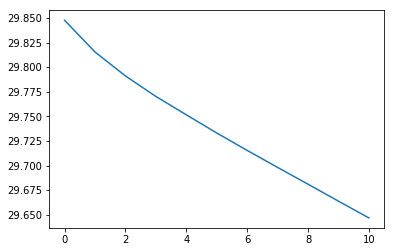

In [31]:
plt.plot(losses)

In [101]:
k=4
graphx = train_data[k]
true_labels = graphx.graph['true_labels']

means, sigmas, loss_m = run_message_passing(graphx=graphx, params_mpnn=params_mpnn)
clusters = laplacian_clusters((means, sigmas), true_labels)
l1 = loss_similar_laplacian_mean_div((means, sigmas), true_labels, clusters)
l2 = loss_distinct_laplacian_mean_div(clusters)
loss = l1 + l2# + loss_m / 100

print(loss.item())
plot_graphx(graphx)
plot_clusters(means, true_labels, azim=0, elev=90)
plot_clusters(means, true_labels, azim=45)

ValueError: not enough values to unpack (expected 3, got 2)